In [1]:
%matplotlib inline
from chestnet_utils import *
from imblearn.over_sampling import SMOTE
%load_ext autoreload
%autoreload 2

In [2]:
class XRayDataset1(Dataset):
    
    def __init__(self, csv_file, path, transform = None,is_train=True, subset=700):
        self.df = pd.read_csv(csv_file)
        
        self.path = path
        self.transform = transform
        self.is_train = is_train
        
        if is_train:
            self.df['detected_id'] = self.df.detected.astype('category').cat.codes
            self.idx_to_classes = dict(enumerate(self.df.detected.astype('category').cat.categories))
            self.subset = subset
            self.class_weights = compute_class_weight('balanced',np.arange(14),self.df.detected.astype('category').cat.codes)
            indices = np.arange(len(self.df))
            self.tr_idx,self.val_idx =  train_test_split(indices,test_size=0.2,random_state=42)
            self.os_dt = oversample_data(self.df.loc[self.tr_idx],self.transform,self.subset,self.path)
            self.sml_val_idx = np.random.choice(self.val_idx,size=int(self.subset * 0.2),replace=False)
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,idx):
        
        if self.is_train:
            img_path = os.path.join(self.path,'train_',self.df.loc[idx,'image_name'])
        else:
            img_path = os.path.join(self.path,'test_',self.df.loc[idx,'image_name'])
        
        img = cv2.imread(img_path,1)
        if self.is_train:
            label = self.df.loc[idx,'detected_id'] # detected id is cat converted to numbers
            sample = {'image':img,
                  'label':label
                 }
        else:
            sample = {'image':img,
                      'label':0
                     }
            
        
        if self.transform:
            if self.is_train:
                if idx in self.val_idx:
                    sample['image'] = self.transform['test_aug'](sample['image'])
                else:
                    sample['image'] = self.transform['train_aug'](sample['image'])
            else:
                sample['image'] = self.transform['test_aug'](sample['image'])
            
        return sample 

In [3]:
labels_tr = pd.read_csv(f'{data_folder}train.csv')
labels_tr.head()

,row_id,age,gender,view_position,image_name,detected
0,id_0,45,M,0,scan_0000.png,class_3
1,id_1,57,F,0,scan_0001.png,class_3
2,id_10,58,M,0,scan_00010.png,class_3
3,id_1000,64,M,0,scan_0001000.png,class_6
4,id_10000,33,M,1,scan_00010000.png,class_3


In [4]:
labels_tr.loc[[3,54,62,23,3]]

,row_id,age,gender,view_position,image_name,detected
3,id_1000,64,M,0,scan_0001000.png,class_6
54,id_10074,38,F,0,scan_00010074.png,class_2
62,id_10082,48,M,1,scan_00010082.png,class_2
23,id_10032,52,F,0,scan_00010032.png,class_12
3,id_1000,64,M,0,scan_0001000.png,class_6


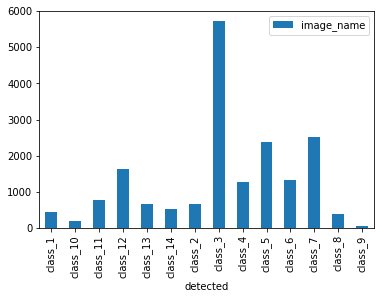

In [8]:
classes = pd.Series(['class_1','class_2', 'class_3', 'class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13','class_14',])
labels_tr.groupby('detected').count().reset_index().plot(kind='bar', x='detected',y='image_name')

In [20]:
id_to_img_name = dict(enumerate(labels_tr.image_name.astype('category').cat.categories))
labels_tr['image_name_id'] = labels_tr.image_name.astype('category').cat.codes
len(id_to_img_name)

id_to_row_id = dict(enumerate(labels_tr.row_id.astype('category').cat.categories))
labels_tr['row_id_num_id'] = labels_tr.row_id.astype('category').cat.codes
len(id_to_row_id)

id_to_gender = dict(enumerate(labels_tr.gender.astype('category').cat.categories))
labels_tr['gender_id'] = labels_tr.gender.astype('category').cat.codes
len(id_to_gender)

id_to_detected = dict(enumerate(labels_tr.detected.astype('category').cat.categories))
labels_tr['detected_id'] = labels_tr.detected.astype('category').cat.codes
len(id_to_detected)

18577

In [31]:
labels_tr.head().columns

Index(['row_id', 'age', 'gender', 'view_position', 'image_name', 'detected',
       'image_name_id', 'row_id_num_id', 'gender_id', 'detected_id'],
      dtype='object')

In [29]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_res, y_res = sm.fit_sample(labels_tr.drop(['detected','row_id','image_name','gender','detected_id'],axis=1), labels_tr['detected_id'])
print(labels_tr['detected'].value_counts(), np.bincount(y_res))

/home/ubuntu/src/anaconda3/envs/my_root/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


class_3     5728
class_7     2529
class_5     2373
class_12    1623
class_6     1316
class_4     1283
class_11     786
class_13     676
class_2      656
class_14     535
class_1      436
class_8      377
class_10     193
class_9       66
Name: detected, dtype: int64 [5728 5728 5728 5728 5728 5728 5728 5728 5728 5728 5728 5728 5728 5728]


In [43]:
smpled = pd.DataFrame(x_res,columns=(['age', 'view_position', 'image_name', 'row_id', 'gender']))

In [45]:
smpled['detected'] = pd.Series(y_res)

In [ ]:
new = smpled.replace({'detected':id_to_detected,'gender':id_to_gender,'image_name':id_to_img_name,'row_id':id_to_row_id})
new.gender.unique()

In [3]:
class oversample_data(Dataset):
    
    def __init__(self,labels_tr,transform,subset,path):
        self.labels_tr = labels_tr
        self.transform = transform
        self.path = path
        self.subset = subset
        
        self.id_to_img_name = dict(enumerate(self.labels_tr.image_name.astype('category').cat.categories))
        self.labels_tr['image_name_id'] = self.labels_tr.image_name.astype('category').cat.codes

        self.id_to_row_id = dict(enumerate(self.labels_tr.row_id.astype('category').cat.categories))
        self.labels_tr['row_id_num_id'] = self.labels_tr.row_id.astype('category').cat.codes

        self.id_to_gender = dict(enumerate(self.labels_tr.gender.astype('category').cat.categories))
        self.labels_tr['gender_id'] = self.labels_tr.gender.astype('category').cat.codes

        self.id_to_detected = dict(enumerate(self.labels_tr.detected.astype('category').cat.categories))
        self.labels_tr['detected_id'] = self.labels_tr.detected.astype('category').cat.codes

        sm = SMOTE(random_state=12, ratio = 1.0)
        x_res, y_res = sm.fit_sample(labels_tr.drop(['detected','row_id','image_name','gender','detected_id'],axis=1), self.labels_tr['detected_id'])
        
        self.labels_tr = pd.DataFrame(x_res,columns=(['age', 'view_position', 'image_name', 'row_id', 'gender']))
        self.labels_tr['detected_id'] = pd.Series(y_res)
        
        self.sml_tr_idx = np.random.choice(len(self.labels_tr),size=self.subset,replace=False)
        
    def __len__(self):
        return(len(self.labels_tr))
        
    def __getitem__(self,idx):
        img_path = os.path.join(self.path,'train_',self.id_to_img_name[int(self.labels_tr.loc[idx,'image_name'])])
        img = cv2.imread(img_path,1)
        label = self.labels_tr.loc[idx,'detected_id'] # detected id is cat converted to numbers
        sample = {'image':img,
                  'label':label
                 }
        
        if self.transform:
            sample['image'] = self.transform['train_aug'](sample['image'])
        
        return sample  
        
        



In [103]:
def get_dataloaders(dataset,bs,num_workers,use_gpu,fr):
    mini = int(len(dataset.os_dt) * fr)
    temp = np.random.choice(len(dataset.os_dt), size=mini, replace=False)
    train_sampler = sampler.SubsetRandomSampler(temp)
    val_sampler = sampler.SubsetRandomSampler(dataset.val_idx)
    small_train_sampler = sampler.SubsetRandomSampler(dataset.os_dt.sml_tr_idx)
    small_val_sampler = sampler.SubsetRandomSampler(dataset.sml_val_idx)

    samplers = {
        'train':train_sampler,
        'val': val_sampler,
        'sml_tr':small_train_sampler,
        'sml_val':small_val_sampler
    }
    
    which_dt = {
        'train':dataset.os_dt,
        'val': dataset,
        'sml_tr':dataset.os_dt,
        'sml_val':dataset
    }

    dataloaders = {k : DataLoader(which_dt[k],
                            batch_size=bs,
                            sampler=v,
                            num_workers=num_workers,
                            pin_memory=use_gpu
                           ) for k,v in samplers.items()}

    
    return samplers, dataloaders

In [104]:
def get_dt_szs(samplers):
    dataset_sizes = {k : len(v) for k,v in samplers.items()}
    return dataset_sizes

In [105]:
model_ft = models.resnet34(pretrained=True)
for i,param in enumerate(model_ft.parameters()):
    if i ==  10:
        break
    param.requires_grad = False
model_ft.conv1.kernel_size = (3,3)
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
model_ft.fc = nn.Sequential(nn.Dropout(0.7,True),nn.Linear(512, 14)) #after avgpool the size comes out to be features 2048

if use_gpu:
    model_ft = model_ft.cuda()

In [114]:
tfms = get_tfms(100)

transformed_dataset = XRayDataset1(f'{data_folder}train.csv',f'{data_folder}',transform=tfms)

use_gpu, num_workers = get_pm_for_dl()

samplers, dataloaders = get_dataloaders(transformed_dataset,32,num_workers,use_gpu,0.1)
dataset_sizes = get_dt_szs(samplers)

/home/ubuntu/src/anaconda3/envs/my_root/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [115]:
dataset_sizes

{'sml_tr': 700, 'sml_val': 140, 'train': 6468, 'val': 3716}

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=1e-4)
exp_lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.7)
model_ft,b_acc,wts = train_model(model_ft, criterion, optimizer_ft, None,dataloaders,dataset_sizes,3,data_split=['train','sml_val'],save_model=True,name='_rn50_os_dt_')

Epoch 0/2
----------
if train
train Loss: 0.0855 Acc: 0.0696
else sml_val
sml_val Loss: 0.0957 Acc: 0.0500
setting best
Epoch 1/2
----------
if train


In [111]:
pdted,lbs = predict(model_ft,'sml_val',dataloaders,dataset_sizes,criterion)

sml_val
sml_val Loss: 0.0378 Acc: 0.0357


In [112]:
np.bincount(pdted)

array([14, 67,  1,  9,  0,  2,  4,  0, 18,  0,  2,  7,  8,  8])

In [113]:
np.bincount(lbs)

array([ 3,  2,  4, 14,  3,  3,  6, 37,  9, 19, 14, 22,  2,  2])